In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as ticker
from textblob import TextBlob
from langdetect import detect
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# CSV-Datei laden
file_path = '/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/reduced/lyrics_minimal.csv'
df = pd.read_csv(file_path)
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Time For a 187,rap,Master P,1996,1929,{},"[Intro]\nUhhh, niggas done fucked up\nNigga, i...",30703,en,en,en
1,Tomorrow,rap,Rocko,2008,1117,{},"[Intro]\nHey, hey\nDrama, ay! Lemme ask you a ...",40343,en,en,en
2,Getto Mentalitee,rap,Onyx,1995,2844,"{""All City"",""Panama P.I.""}",[Fredro Starr]\nYou roll a hundred niggas deep...,36057,en,en,en
3,Growin Old,rap,Pigeon John,2006,370,{},"[Intro]\nChaka Zulu, Chak, Chaka Zulua. Oh, ye...",37164,en,en,en
4,Do Your Thing,rap,Erick Sermon,1995,818,{},[Intro: Erick Sermon]\nCheck it one two (it's ...,41778,en,en,en


In [16]:
# Vorbereitung der ML-Datensätze
# Funktion zur Bereinigung von Texten
def clean_text(text):
    if pd.isna(text):
        return ""
    # Text in Kleinbuchstaben umwandeln und Sonderzeichen entfernen
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# NaN-Werte in 'lyrics' durch leere Strings ersetzen
df['lyrics'] = df['lyrics'].fillna('')

# Textbereinigung für alle Liedtexte
df['cleaned_lyrics'] = df['lyrics'].apply(clean_text)

# Wir beschränken uns auf Einträge mit gültigen Tags, Jahren und Views
ml_df = df.dropna(subset=['tag', 'year', 'views']).copy()

## Genrevorhersage

In [17]:
### Genre-Vorhersage (Tag)
# Wir beschränken uns auf die häufigsten Genres für bessere Klassifikation
top_genres = ml_df['tag'].value_counts().head(10).index
genre_df = ml_df[ml_df['tag'].isin(top_genres)].copy()

# Label-Encoder für Genre
le = LabelEncoder()
genre_df['genre_encoded'] = le.fit_transform(genre_df['tag'])

# Aufteilung in Trainings- und Testdaten
X = genre_df['cleaned_lyrics']
y = genre_df['genre_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature-Extraktion mit TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Naive Bayes Klassifikationsergebnisse:
Genauigkeit: 0.8900
              precision    recall  f1-score   support

     country       0.00      0.00      0.00         2
        misc       0.00      0.00      0.00         6
         pop       0.89      1.00      0.94        89
         rap       0.00      0.00      0.00         1
          rb       0.00      0.00      0.00         2

    accuracy                           0.89       100
   macro avg       0.18      0.20      0.19       100
weighted avg       0.79      0.89      0.84       100


SVM Klassifikationsergebnisse:
Genauigkeit: 0.8900
              precision    recall  f1-score   support

     country       0.00      0.00      0.00         2
        misc       0.00      0.00      0.00         6
         pop       0.89      1.00      0.94        89
         rap       0.00      0.00      0.00         1
          rb       0.00      0.00      0.00         2

    accuracy                           0.89       100
   macro avg       0

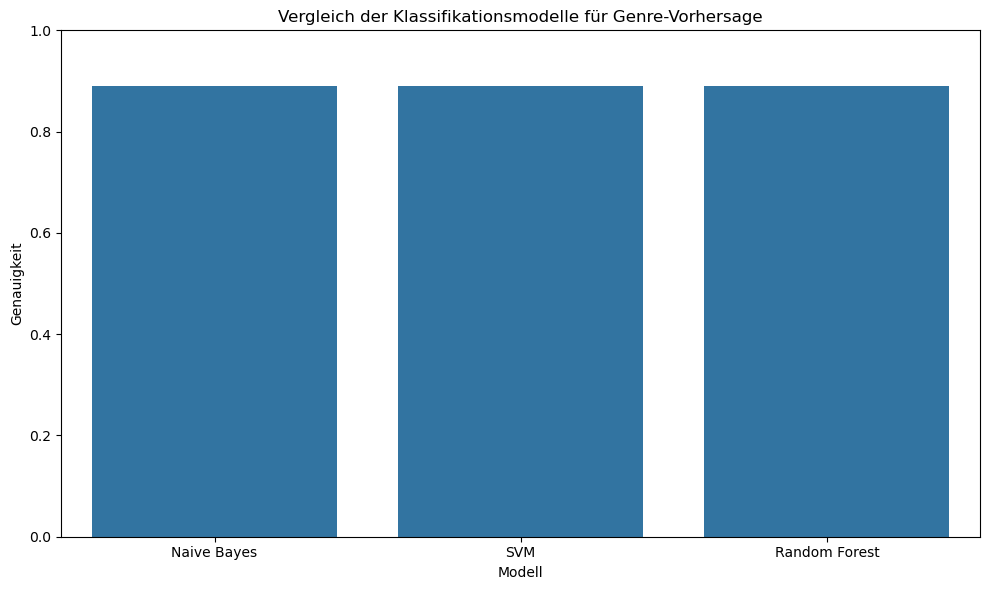

In [18]:
# 1. Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_predictions = nb_model.predict(X_test_tfidf)

print("Naive Bayes Klassifikationsergebnisse:")
print(f"Genauigkeit: {accuracy_score(y_test, nb_predictions):.4f}")
print(classification_report(y_test, nb_predictions, target_names=le.classes_, labels=np.unique(y_test)))

# 2. Support Vector Machine
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

print("\nSVM Klassifikationsergebnisse:")
print(f"Genauigkeit: {accuracy_score(y_test, svm_predictions):.4f}")
print(classification_report(y_test, svm_predictions, target_names=le.classes_, labels=np.unique(y_test)))

# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_predictions = rf_model.predict(X_test_tfidf)

print("\nRandom Forest Klassifikationsergebnisse:")
print(f"Genauigkeit: {accuracy_score(y_test, rf_predictions):.4f}")
print(classification_report(y_test, rf_predictions, target_names=le.classes_, labels=np.unique(y_test)))

# Vergleich der Klassifikationsmodelle
models = ['Naive Bayes', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, nb_predictions),
    accuracy_score(y_test, svm_predictions),
    accuracy_score(y_test, rf_predictions)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Vergleich der Klassifikationsmodelle für Genre-Vorhersage')
plt.xlabel('Modell')
plt.ylabel('Genauigkeit')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Beliebtheitsvorhersage (Views)

Lineare Regression für Beliebtheitsvorhersage:
RMSE: 10.2294
R²: -22.1331

Ridge Regression für Beliebtheitsvorhersage:
RMSE: 1.9244
R²: 0.1813


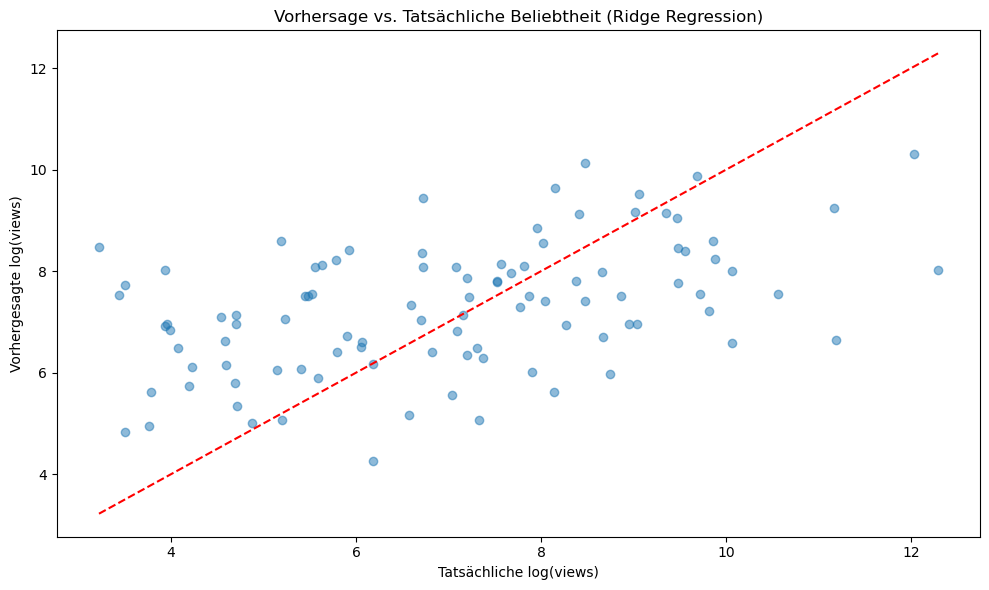

In [19]:
### Beliebtheitsvorhersage (Views)
# Vorbereitung der Daten für die Beliebtheitsvorhersage
popularity_df = ml_df.dropna(subset=['views', 'year']).copy()

# Log-Transformation der Views (typischerweise sehr schiefe Verteilung)
popularity_df['log_views'] = np.log1p(popularity_df['views'])

# Feature-Extraktion
# Wir verwenden Jahr als numerisches Feature
popularity_df['year'] = popularity_df['year'].astype(float)

# Label-Encoding für Künstler
artist_encoder = LabelEncoder()
popularity_df['artist_encoded'] = artist_encoder.fit_transform(popularity_df['artist'])

# TF-IDF für Liedtexte (mit weniger Features für Performance)
tfidf_pop = TfidfVectorizer(max_features=2000, min_df=10)
lyrics_features = tfidf_pop.fit_transform(popularity_df['cleaned_lyrics'])

# Erstellen einer Feature-Matrix
# Wir kombinieren Textmerkmale mit Jahr und Künstler
from scipy.sparse import hstack
X_features = hstack([
    lyrics_features,
    popularity_df[['year', 'artist_encoded']].to_numpy()
])

# Zielvariable
y_views = popularity_df['log_views'].values

# Aufteilung in Trainings- und Testdaten
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(
    X_features, y_views, test_size=0.2, random_state=42
)

# 1. Lineare Regression
lr_model = LinearRegression()
lr_model.fit(X_train_pop, y_train_pop)
lr_predictions = lr_model.predict(X_test_pop)

# 2. Ridge Regression (regulierte Regression)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_pop, y_train_pop)
ridge_predictions = ridge_model.predict(X_test_pop)

# Modellbewertung
print("Lineare Regression für Beliebtheitsvorhersage:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_pop, lr_predictions)):.4f}")
print(f"R²: {r2_score(y_test_pop, lr_predictions):.4f}")

print("\nRidge Regression für Beliebtheitsvorhersage:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_pop, ridge_predictions)):.4f}")
print(f"R²: {r2_score(y_test_pop, ridge_predictions):.4f}")

# Visualisierung der Vorhersagen vs. tatsächliche Werte
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pop, ridge_predictions, alpha=0.5)
plt.plot([y_test_pop.min(), y_test_pop.max()], [y_test_pop.min(), y_test_pop.max()], 'r--')
plt.xlabel('Tatsächliche log(views)')
plt.ylabel('Vorhergesagte log(views)')
plt.title('Vorhersage vs. Tatsächliche Beliebtheit (Ridge Regression)')
plt.tight_layout()
plt.show()

## Feature-Importance für die Beliebtheit

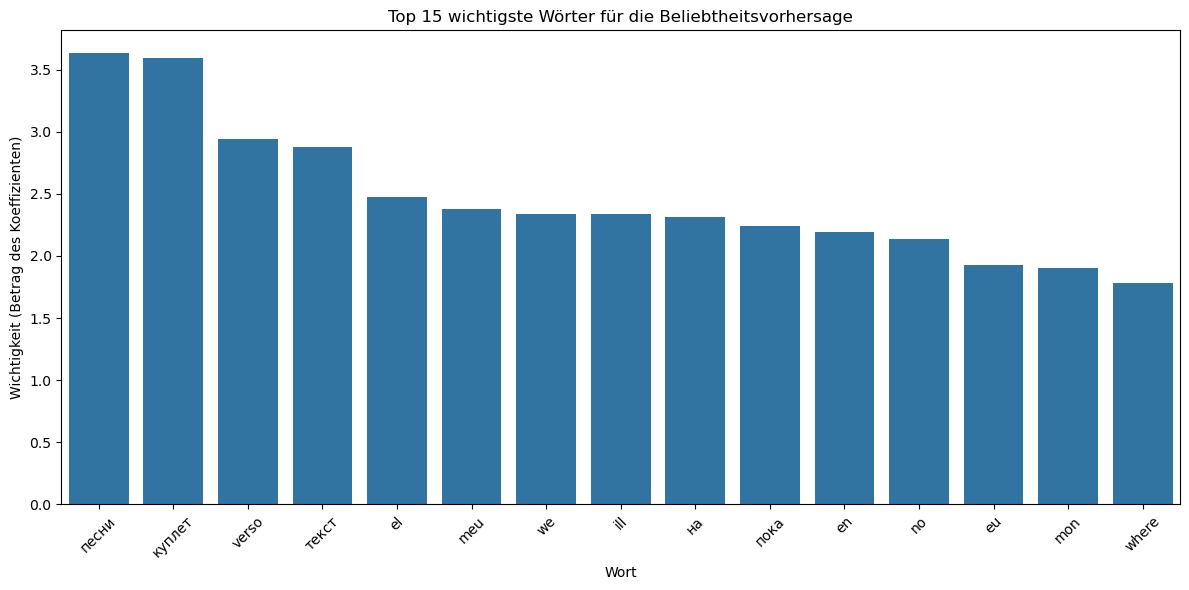

In [21]:
# Feature-Importance für die Beliebtheit (basierend auf den Ridge-Koeffizienten für die TF-IDF-Features)
tfidf_feature_names = tfidf_pop.get_feature_names_out()
tfidf_coefs = ridge_model.coef_[:len(tfidf_feature_names)]

# Top-15 wichtigste Wörter
word_importance = pd.DataFrame({
    'word': tfidf_feature_names,
    'importance': np.abs(tfidf_coefs)
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='importance', data=word_importance)
plt.title('Top 15 wichtigste Wörter für die Beliebtheitsvorhersage')
plt.xlabel('Wort')
plt.ylabel('Wichtigkeit (Betrag des Koeffizienten)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Naive Bayes für Spracherkennung:

Naive Bayes für Spracherkennung:
Genauigkeit: 1.0000
              precision    recall  f1-score   support

          en       1.00      1.00      1.00        20
          es       1.00      1.00      1.00        20
          fr       1.00      1.00      1.00        20
          pt       1.00      1.00      1.00        20
          ru       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



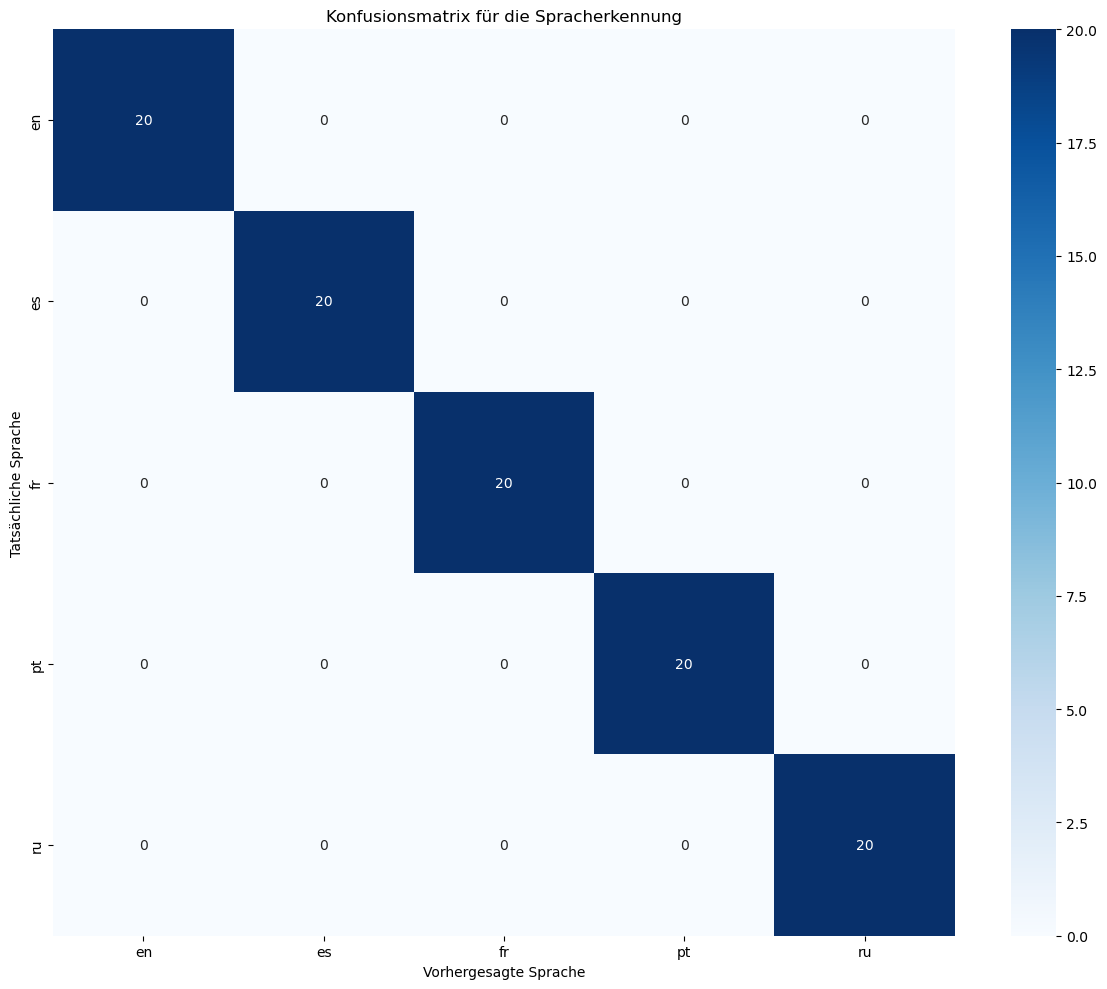

In [22]:
# Vorbereitung der Daten für die Spracherkennung
# Wir nehmen nur Einträge mit bekannter Sprache
lang_df = df.dropna(subset=['language', 'lyrics']).copy()

# Top 10 häufigste Sprachen für bessere Klassifikation
top_languages = lang_df['language'].value_counts().head(10).index
lang_df = lang_df[lang_df['language'].isin(top_languages)].copy()

# Label-Encoder für Sprachen
lang_encoder = LabelEncoder()
lang_df['language_encoded'] = lang_encoder.fit_transform(lang_df['language'])

# Feature-Extraktion - wir verwenden Character-level n-Gramme (gut für Sprachmerkmale)
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4), max_features=5000)
X_lang = char_vectorizer.fit_transform(lang_df['cleaned_lyrics'])
y_lang = lang_df['language_encoded']

# Aufteilung in Trainings- und Testdaten
X_train_lang, X_test_lang, y_train_lang, y_test_lang = train_test_split(
    X_lang, y_lang, test_size=0.2, random_state=42, stratify=y_lang
)

# Naive Bayes für Spracherkennung (oft sehr effektiv für diese Aufgabe)
nb_lang_model = MultinomialNB()
nb_lang_model.fit(X_train_lang, y_train_lang)
nb_lang_predictions = nb_lang_model.predict(X_test_lang)

# Modellbewertung
print("Naive Bayes für Spracherkennung:")
print(f"Genauigkeit: {accuracy_score(y_test_lang, nb_lang_predictions):.4f}")
print(classification_report(y_test_lang, nb_lang_predictions, target_names=lang_encoder.classes_))

# Konfusionsmatrix für die Spracherkennung
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_lang, nb_lang_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=lang_encoder.classes_,
           yticklabels=lang_encoder.classes_)
plt.title('Konfusionsmatrix für die Spracherkennung')
plt.xlabel('Vorhergesagte Sprache')
plt.ylabel('Tatsächliche Sprache')
plt.tight_layout()
plt.show()

## Sentiment-Analyse

Sentiment in der Textanalyse bezieht sich auf die emotionale Grundhaltung, die in einem Text ausgedrückt wird. Ziel der Sentimentanalyse ist es, diese Stimmung als positiv, negativ oder neutral zu klassifizieren und oft auch eine Intensität zu messen.

Die vorliegende Grafik zeigt das durchschnittliche Sentiment für verschiedene Musikgenres. Jeder Balken repräsentiert ein Genre (Pop, Country, Rap, Rock), und die Höhe des Balkens gibt an, wie positiv oder negativ die durchschnittliche Stimmung der Liedtexte in diesem Genre ist. Beispielsweise haben Rock-Songs im Durchschnitt ein deutlich positiveres Sentiment als Pop- oder Country-Songs.


In [32]:
# Wir beschränken uns auf Einträge, bei denen beide Sprachmodelle 'en' (Englisch) als Sprache identifiziert haben
english_df = df[df['language'] == 'en'].copy()

# Vorbereitung der ML-Datensätze (diese Schritte behalten wir bei, da sie für die weitere Analyse nützlich sein könnten)
# Funktion zur Bereinigung von Texten
def clean_text(text):
    if pd.isna(text):
        return ""
    # Text in Kleinbuchstaben umwandeln und Sonderzeichen entfernen
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# NaN-Werte in 'lyrics' durch leere Strings ersetzen
english_df['lyrics'] = english_df['lyrics'].fillna('')

# Textbereinigung für alle Liedtexte
english_df['cleaned_lyrics'] = english_df['lyrics'].apply(clean_text)

# Wir beschränken uns auf Einträge mit gültigen Tags, Jahren und Views (auch hier behalten wir den Filter bei)
ml_english_df = english_df.dropna(subset=['tag', 'year', 'views']).copy()

print(f"Anzahl der ursprünglichen Einträge: {len(df)}")
print(f"Anzahl der englischsprachigen Einträge: {len(ml_english_df)}")
print("\nErste Zeilen des gefilterten Datensatzes:")
print(ml_english_df.head())

Anzahl der ursprünglichen Einträge: 500
Anzahl der englischsprachigen Einträge: 100

Erste Zeilen des gefilterten Datensatzes:
              title  tag        artist  year  views  \
0    Time For a 187  rap      Master P  1996   1929   
1          Tomorrow  rap         Rocko  2008   1117   
2  Getto Mentalitee  rap          Onyx  1995   2844   
3        Growin Old  rap   Pigeon John  2006    370   
4     Do Your Thing  rap  Erick Sermon  1995    818   

                     features  \
0                          {}   
1                          {}   
2  {"All City","Panama P.I."}   
3                          {}   
4                          {}   

                                              lyrics     id language_cld3  \
0  [Intro]\nUhhh, niggas done fucked up\nNigga, i...  30703            en   
1  [Intro]\nHey, hey\nDrama, ay! Lemme ask you a ...  40343            en   
2  [Fredro Starr]\nYou roll a hundred niggas deep...  36057            en   
3  [Intro]\nChaka Zulu, Chak, Chaka

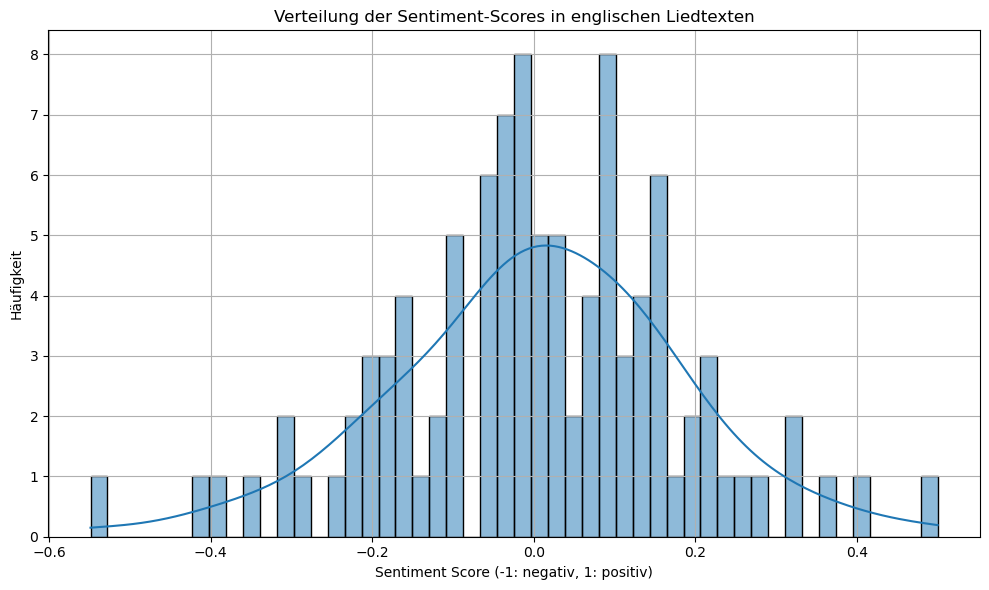

In [33]:
### Sentiment-Analyse

# Sentiment-Analyse für englische Texte
# Wir verwenden TextBlob für eine einfache Sentiment-Analyse

def get_sentiment(text):
    if pd.isna(text):
        return np.nan
    # TextBlob für Sentiment-Analyse verwenden
    analysis = TextBlob(str(text))
    # Polarität: -1 (sehr negativ) bis 1 (sehr positiv)
    return analysis.sentiment.polarity

# Sentiment für englische Texte berechnen
english_df['sentiment'] = english_df['lyrics'].apply(get_sentiment)

# Verteilung der Sentiments
plt.figure(figsize=(10, 6))
sns.histplot(english_df['sentiment'], bins=50, kde=True)
plt.title('Verteilung der Sentiment-Scores in englischen Liedtexten')
plt.xlabel('Sentiment Score (-1: negativ, 1: positiv)')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.tight_layout()
plt.show()

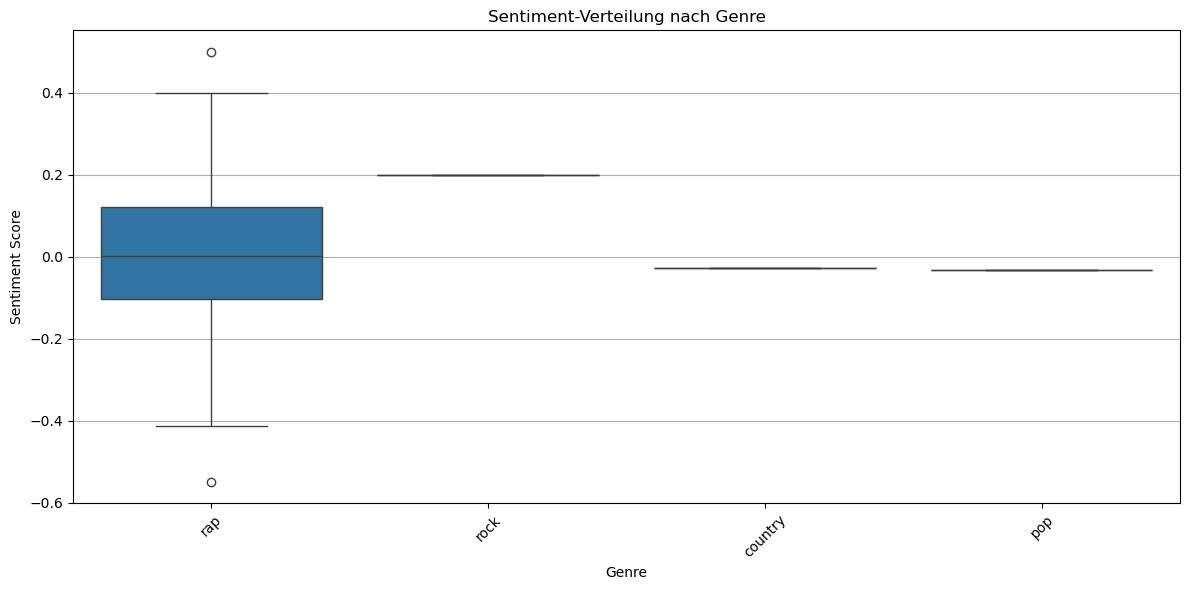

In [34]:
# Sentiment nach Genre für die Top-10 Genres
top10_genres = english_df['tag'].value_counts().head(10).index
genre_sentiment = english_df[english_df['tag'].isin(top10_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='tag', y='sentiment', data=genre_sentiment)
plt.title('Sentiment-Verteilung nach Genre')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

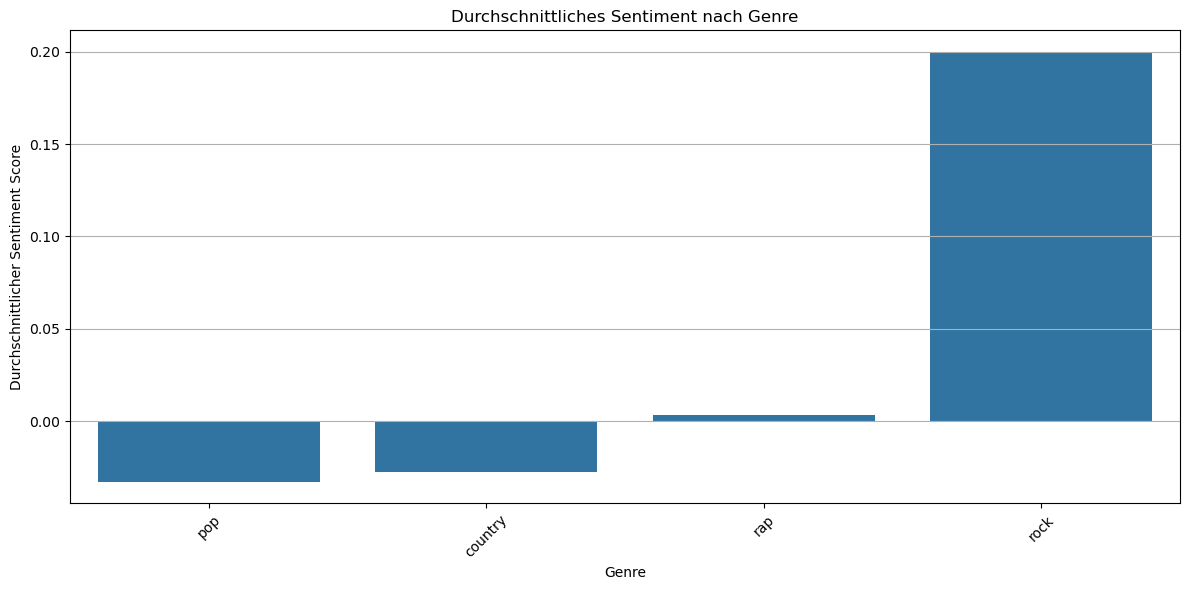

In [35]:
# Durchschnittliches Sentiment nach Genre
avg_sentiment = genre_sentiment.groupby('tag')['sentiment'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sentiment.index, y=avg_sentiment.values)
plt.title('Durchschnittliches Sentiment nach Genre')
plt.xlabel('Genre')
plt.ylabel('Durchschnittlicher Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

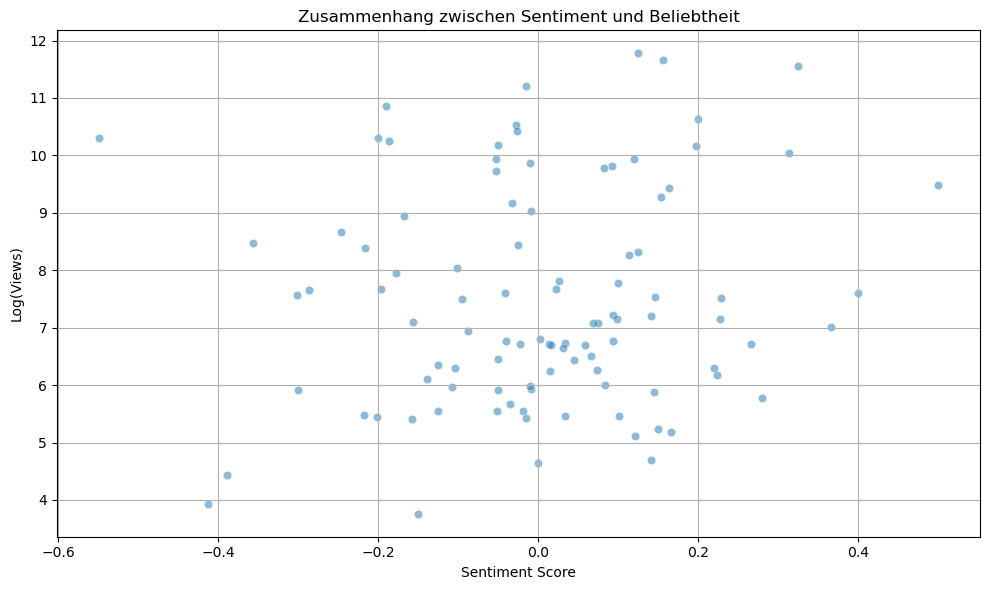

In [36]:
# Sentiment und Beliebtheit
plt.figure(figsize=(10, 6))
# Log-Transformation der Views für bessere Visualisierung
english_df['log_views'] = np.log1p(english_df['views'])
sns.scatterplot(x='sentiment', y='log_views', data=english_df, alpha=0.5)
plt.title('Zusammenhang zwischen Sentiment und Beliebtheit')
plt.xlabel('Sentiment Score')
plt.ylabel('Log(Views)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Themenmodellierung (Topic Modeling)

Thema #1: verse little intro people chorus got man let come like
Thema #2: got live like verse bitch nigga im em real fuck
Thema #3: home time know make like im yeah ive bad right
Thema #4: ha verse just intro cause yeah uh know everybody im
Thema #5: im nigga niggas like know dont yo shit come verse
Thema #6: know aint yeah hard dont leave im shit yall cause
Thema #7: just yall like im dont thats mean yeah uh verse
Thema #8: ive im nigga life boy aint verse house intro whats
Thema #9: im ill yeah rap time like dont black verse shot
Thema #10: world just dont im hard far verse shit wanna thing


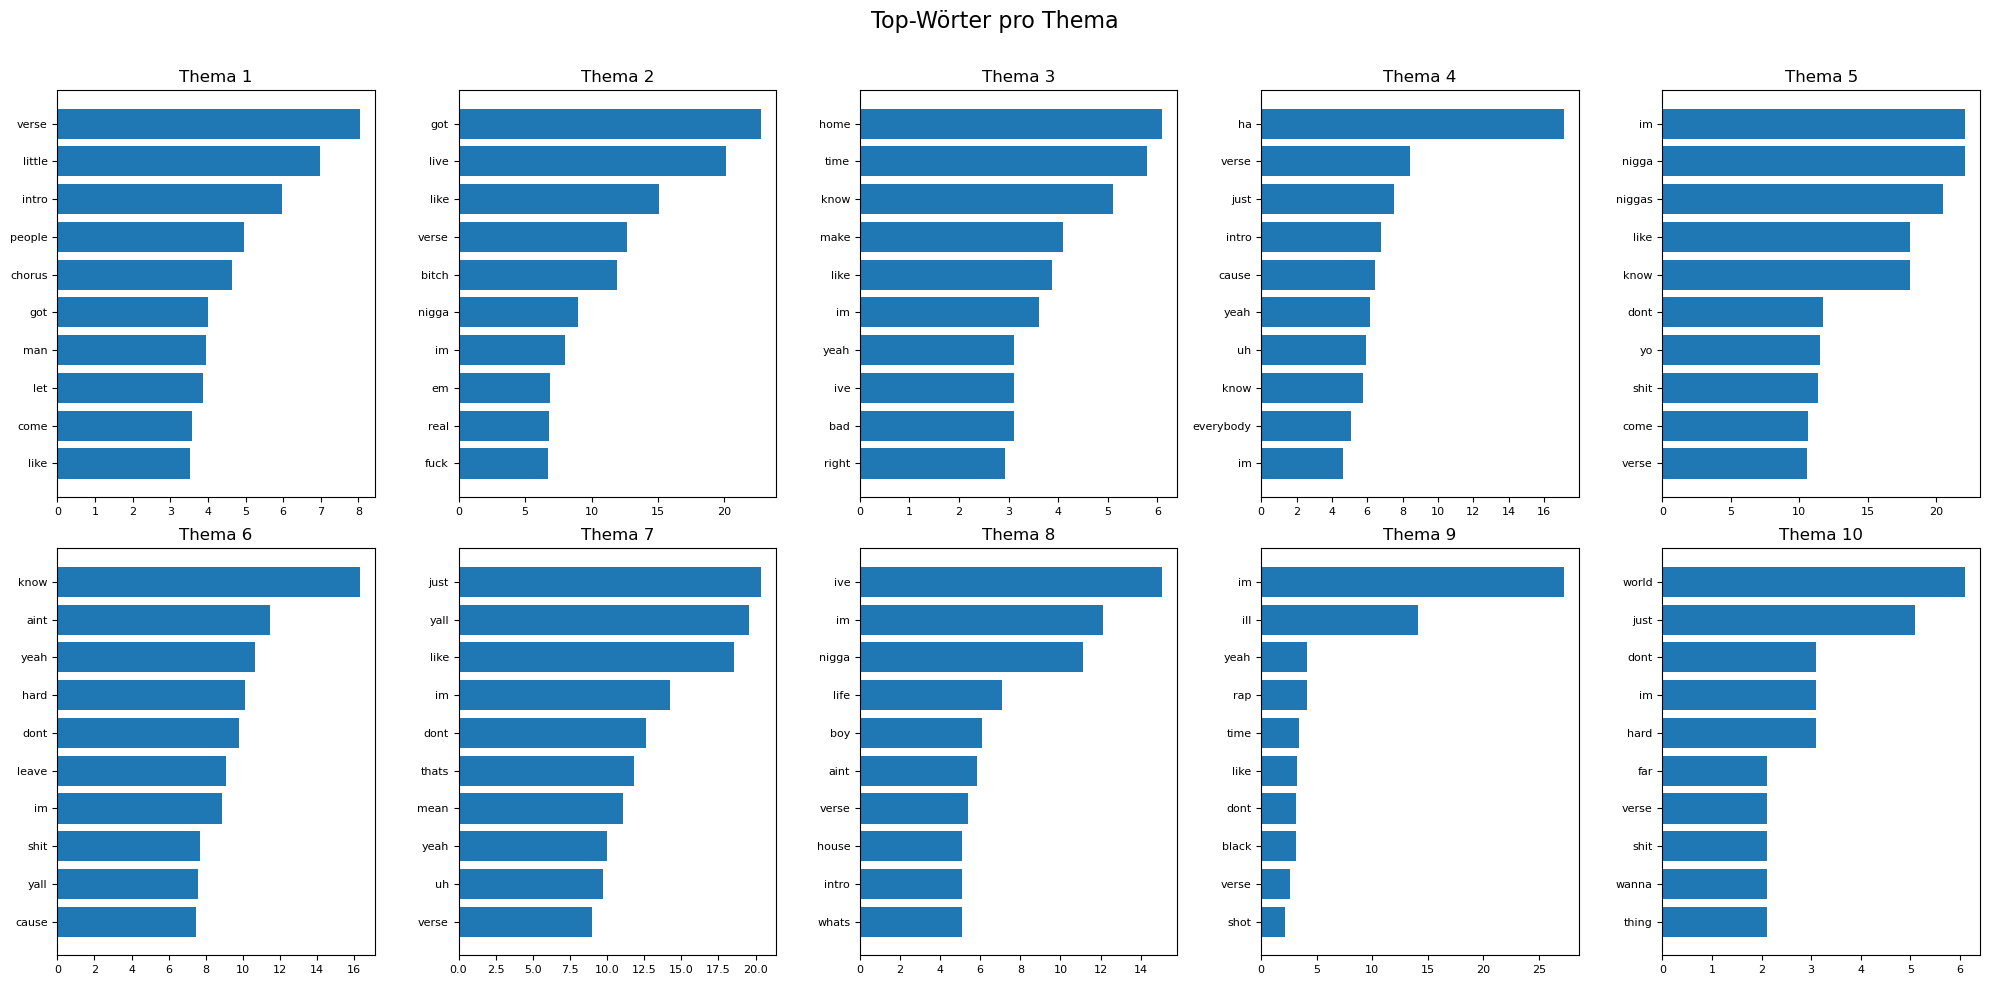

In [37]:
## Themenmodellierung (Topic Modeling)
# Themenmodellierung mit Latent Dirichlet Allocation (LDA)
# Wir beschränken uns auf englische Texte

# Vorbereitung der Texte
vectorizer = CountVectorizer(max_features=5000, min_df=5, stop_words='english')
X_topics = vectorizer.fit_transform(english_df['cleaned_lyrics'])

# LDA-Modell trainieren
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_model.fit(X_topics)

# Top-Wörter für jedes Thema ausgeben
feature_names = vectorizer.get_feature_names_out()

# Funktion zum Anzeigen der Top-Wörter pro Thema
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append((topic_idx, ' '.join(top_words)))
    return topics

# Top 10 Wörter für jedes Thema
topics = display_topics(lda_model, feature_names, 10)
for topic_idx, top_words in topics:
    print(f"Thema #{topic_idx+1}: {top_words}")

# Visualisierung der Top-Wörter für jedes Thema
n_top_words = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = [topic[i] for i in top_words_idx]
    
    ax = axes[topic_idx]
    ax.barh(top_words, top_weights)
    ax.set_title(f'Thema {topic_idx + 1}')
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=8)
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.suptitle('Top-Wörter pro Thema', fontsize=16)
plt.show()